In [1]:
import importlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from biosppy.signals import ecg, tools, ppg
from statannotations.Annotator import Annotator

import signal_utils as signal_functions
importlib.reload(signal_functions)

<module 'signal_utils' from '/home/siri/PycharmProjects/medical-metrics-analysis/src/signal_utils.py'>

In [2]:
# add directory of your data
path_parent = os.path.dirname(os.getcwd())
data_dir = os.path.join(path_parent, 'data/SENSEI_v2')

## uncomment when there are zipped files
#signal_functions.unzip_all(data_dir)

In [3]:
paths_ppg = signal_functions.find_csvs(data_dir, 'wrist_ppg_ambient', '.csv')
paths_label = signal_functions.find_csvs(data_dir, 'label', '.csv')
num_users = len(paths_ppg)
print(paths_ppg)
print(paths_label)

['/home/siri/PycharmProjects/medical-metrics-analysis/data/SENSEI_v2/user_sensei_178/corsano_wrist_ppg_ambient_0/2022-11-08.csv', '/home/siri/PycharmProjects/medical-metrics-analysis/data/SENSEI_v2/user_sensei_223/corsano_wrist_ppg_ambient_0/14-11-2022.csv', '/home/siri/PycharmProjects/medical-metrics-analysis/data/SENSEI_v2/user_sensei_642/corsano_wrist_ppg_ambient_0/2022-11-09.csv', '/home/siri/PycharmProjects/medical-metrics-analysis/data/SENSEI_v2/user_sensei_661/corsano_wrist_ppg_ambient_0/2022-11-10.csv']
['/home/siri/PycharmProjects/medical-metrics-analysis/data/SENSEI_v2/user_sensei_178/sensomative_labels/user_178_2022-11-08_13-30-38-951[1].csv', '/home/siri/PycharmProjects/medical-metrics-analysis/data/SENSEI_v2/user_sensei_223/sensomative_labels/user_223_2022-11-14_15-32-35-310[1].csv', '/home/siri/PycharmProjects/medical-metrics-analysis/data/SENSEI_v2/user_sensei_642/sensomative_labels/user_642_2022-11-09_13-22-11-209[1].csv', '/home/siri/PycharmProjects/medical-metrics-ana

user_sensei_178


<Figure size 432x288 with 0 Axes>

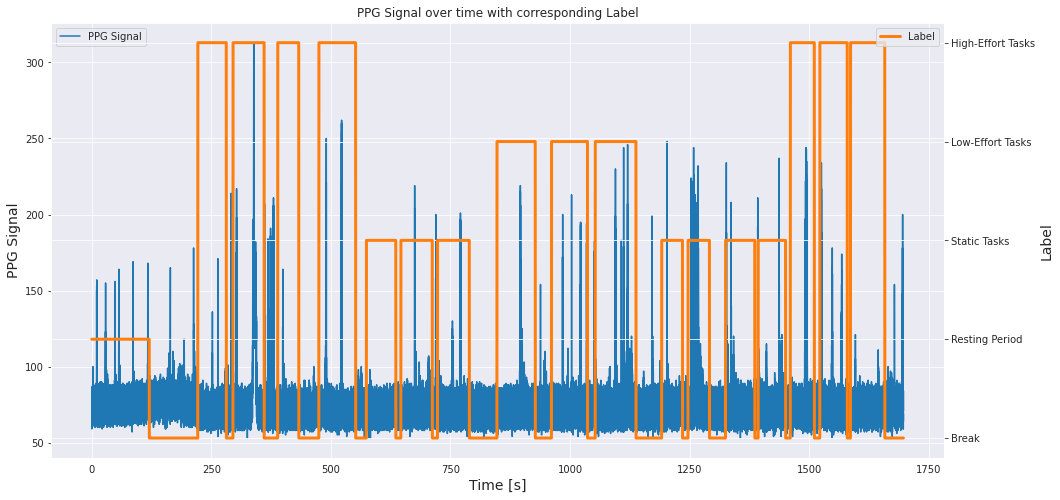

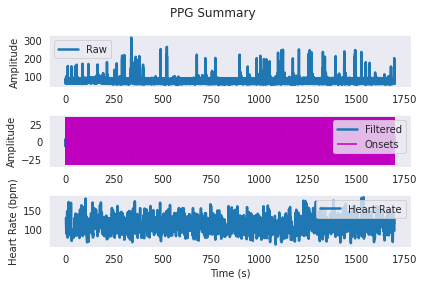

user_sensei_223


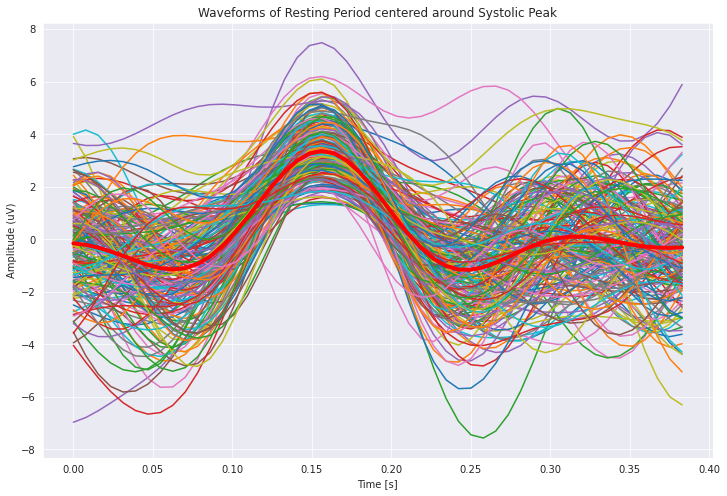

<Figure size 432x288 with 0 Axes>

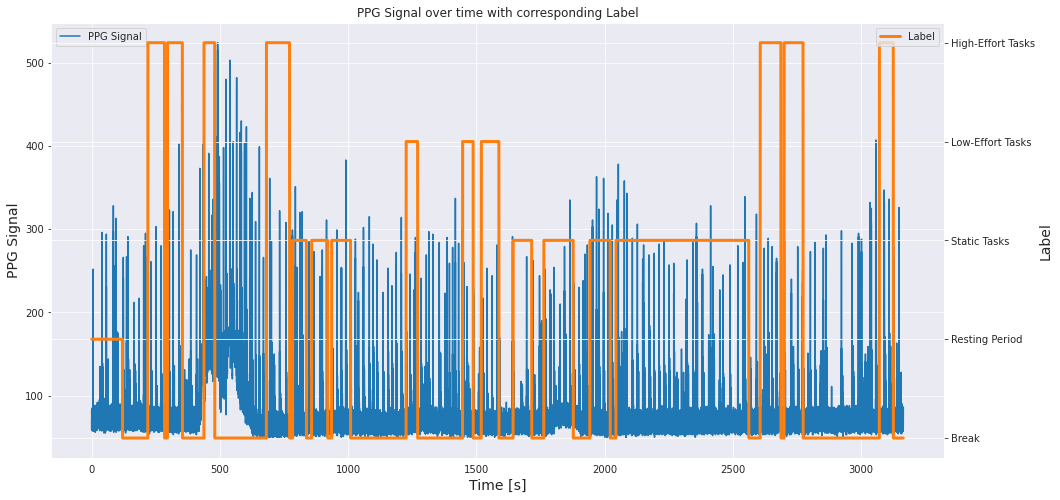

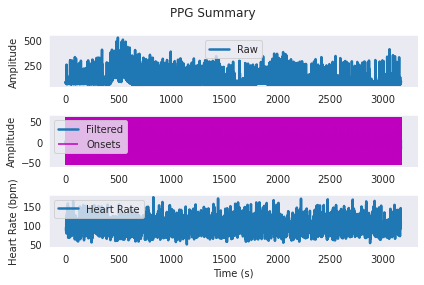

user_sensei_642


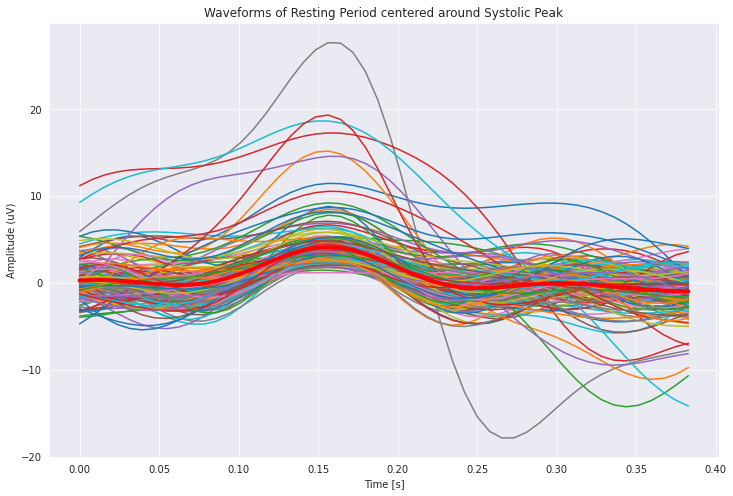

<Figure size 432x288 with 0 Axes>

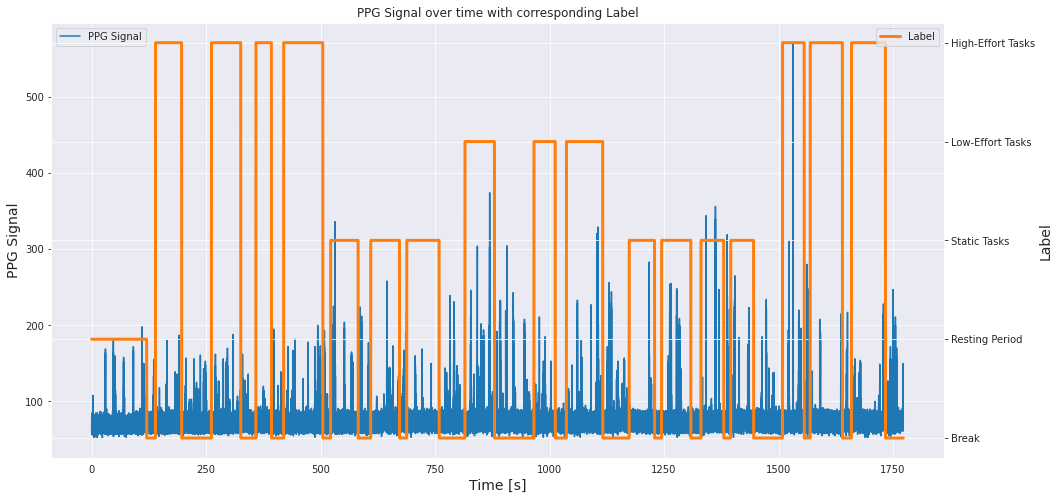

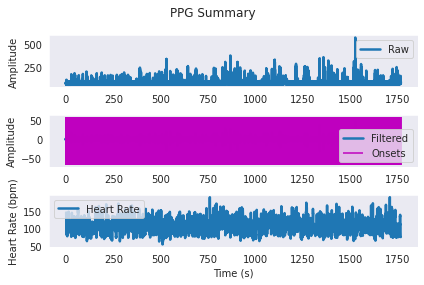

user_sensei_661


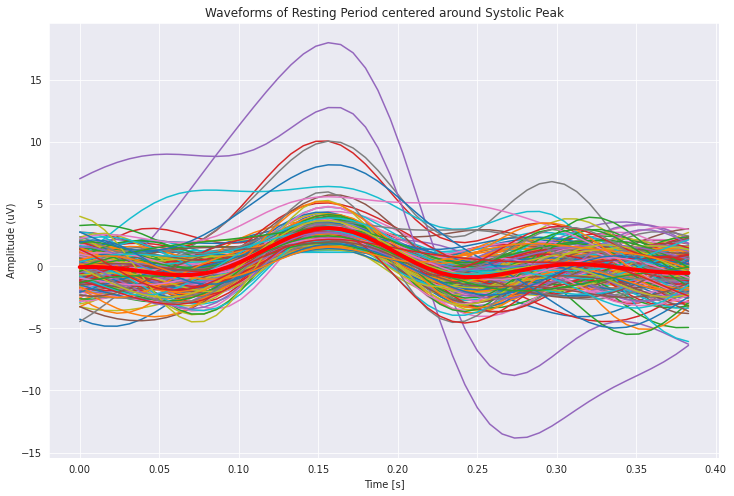

<Figure size 432x288 with 0 Axes>

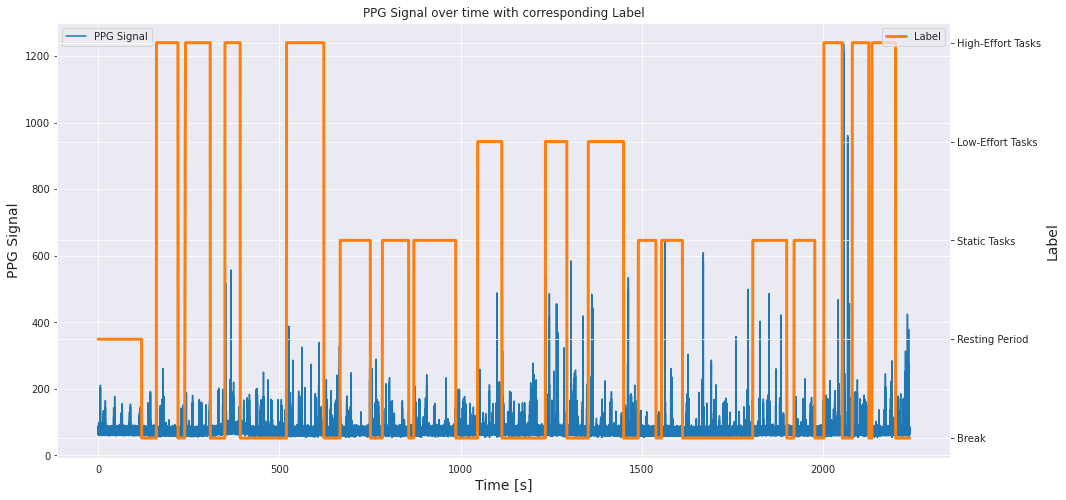

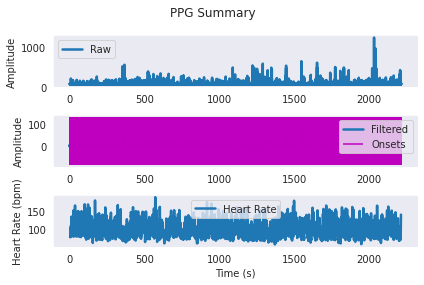

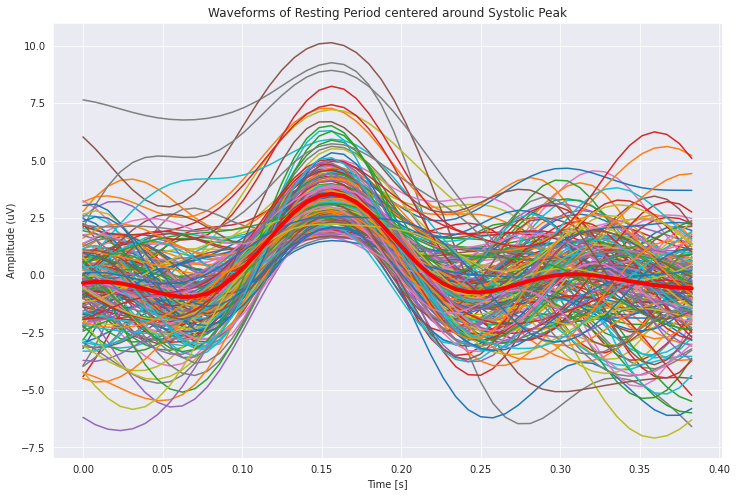

In [4]:
def analyse_adl(path_ppg, path_label, sf=128, show=True):
    df_ppg = pd.read_csv(path_ppg)
    df_labels = pd.read_csv(path_label)
    df_ppg_label = signal_functions.align_labels(df_ppg, df_labels)

    user_name = df_ppg.userId[0]
    print(user_name)

    df_reclassified = signal_functions.reclassify_labels(df_ppg_label)

    df_clean = df_reclassified[df_reclassified.label>=-1]
    time_reset = df_clean.time - df_clean.time.iat[0]
    df_clean.insert(1, "time_reset", time_reset, True)
    df_clean_reset = df_clean.reset_index()

    if show:
        plt.figure()

        fig, ax = plt.subplots(figsize=(16, 8))

        ax.plot(df_clean.time_reset, df_clean.value)
        ax.set_xlabel("Time [s]", fontsize = 14)
        ax.set_ylabel("PPG Signal", fontsize = 14)
        ax.legend(['PPG Signal'], loc='upper left')

        ax2=ax.twinx()
        ax2.plot(df_clean.time_reset, df_clean.label, color="tab:orange", linewidth=3)
        ax2.set_ylabel("Label", fontsize = 14)
        x1 = [-1,0,1,2,3]
        squad = ['Break','Resting Period','Static Tasks','Low-Effort Tasks','High-Effort Tasks']
        ax2.set_yticks(x1, fontsize=30)
        ax2.set_yticklabels(squad, minor=False)
        ax2.legend(['Label'], loc='upper right')
        plt.title("PPG Signal over time with corresponding Label")

    ts, filtered, onsets, heart_rate_ts, heartrate = ppg.ppg(signal=df_clean.value, sampling_rate=sf, show=show)
    hr_t, hr_v = tools.get_heart_rate(onsets,sf)

    ab,a_ind,b_ind=np.intersect1d(onsets,hr_t, return_indices=True)

    temps = []
    for ind, value in enumerate(onsets): #onsets[:-1]
        temps.append(filtered[value-20:value+30])
    templates = np.array(temps)

    new_templates = np.take(templates, a_ind, axis=0)

    skewness, kurtosis, snr = signal_functions.calculate_sqi(new_templates, sf)

    user_num_vector = [user_name] * len(new_templates)
    labels = np.nan * len(new_templates)
    euc_dist = np.nan * len(new_templates)

    df_hr = pd.DataFrame({'user': user_num_vector, 'label': labels, 'time': heart_rate_ts, 'HR': heartrate,'skewness': skewness, 'sqi_kurtosis': kurtosis, 'snr': snr,'euc_distance': euc_dist})

    df_hr_label = signal_functions.align_labels_to_hr(df_hr, df_clean_reset, feat_label="label")

    # calculate mean template of class 0
    class0 = df_hr_label[df_hr_label.label == 0].index.tolist()
    templates0 = np.take(new_templates, class0, axis=0)
    mean_waveform0 = np.nanmean(templates0, axis=0)

    # print mean waveform of class0
    euc0 = signal_functions.euc_dist_quality(templates0, mean_waveform0, sf, show=True, plt_title="Waveforms of Resting Period centered around Systolic Peak")

    # calculate euclidian distance from mean template of class 0
    euc_dist = signal_functions.euc_dist_quality(new_templates, mean_waveform0, sf)
    df_hr_label.euc_distance = euc_dist

    # remove rows without label
    df_hr_label = df_hr_label[np.isnan(df_hr_label.label)==False]

    df_norm = signal_functions.normalize_to_userBaseline(df_hr_label, first_sqi_column=4)

    return df_hr_label, df_norm, user_name

df_adl = pd.DataFrame({'user': [], 'label': [], 'time': [], 'HR': [],'skewness': [], 'sqi_kurtosis': [], 'snr': [],'euc_distance': []})
df_adl_normalized = pd.DataFrame({'user': [], 'label': [], 'time': [], 'HR': [],'skewness': [], 'sqi_kurtosis': [], 'snr': [],'euc_distance': []})
users_list = []

for i in range(num_users):
    new_pd, new_pd_normalized, user_name = analyse_adl(paths_ppg[i], paths_label[i], show=True)
    df_adl = pd.concat([df_adl, new_pd], ignore_index=True)
    df_adl_normalized = pd.concat([df_adl_normalized, new_pd_normalized], ignore_index=True)
    users_list.append(user_name)

In [5]:
df_adl

,user,label,time,HR,skewness,sqi_kurtosis,snr,euc_distance
0,user_sensei_178,0.0,0.945308,129.471264,-0.304971,-1.188341,0.000831,11.893038
1,user_sensei_178,0.0,1.398431,110.077325,-0.045407,-1.347163,0.004244,8.887653
2,user_sensei_178,0.0,2.257802,96.174703,-0.194349,-0.967528,0.000077,10.148508
3,user_sensei_178,0.0,2.953111,95.426603,0.455094,-0.760798,0.007972,4.761622
4,user_sensei_178,0.0,3.414047,89.809048,0.353128,-0.929010,0.000040,10.161512
...,...,...,...,...,...,...,...,...
13917,user_sensei_661,-1.0,2209.656260,77.053517,-1.170399,0.271655,0.005336,91.270803
13918,user_sensei_661,-1.0,2210.367195,82.122322,-0.040800,-1.194537,0.000001,33.143990
13919,user_sensei_661,-1.0,2211.078130,102.809191,0.089560,-1.087961,0.001581,10.840408
13920,user_sensei_661,-1.0,2211.507816,122.084730,0.314959,-1.019060,0.003807,8.370507


In [6]:
# Calculate the average length of a class in seconds

temp_label = 0.0
start = 0

zero_list = []
one_list = []
two_list = []
three_list = []

for i in range(len(df_adl)):
    if df_adl.label[i] != temp_label:
        end = df_adl.time[i]
        diff = end - start

        if temp_label == 0:
            zero_list.append(diff)
        if temp_label == 1:
            one_list.append(diff)
        if temp_label == 2:
            two_list.append(diff)
        if temp_label == 3:
            three_list.append(diff)

        temp_label = df_adl.label[i]
        start = df_adl.time[i]

print("Average total length of activities in resting period: ", sum(zero_list)/num_users)
print("Average total length of activities in static tasks: ", sum(one_list)/num_users)
print("Average total length of activities in low-effort tasks: ", sum(two_list)/num_users)
print("Average total length of activities in high-effort tasks: ", sum(three_list)/num_users)

Average total length of activities in resting period:  119.60697256313401
Average total length of activities in static tasks:  579.4296551854808
Average total length of activities in low-effort tasks:  202.2609391618125
Average total length of activities in high-effort tasks:  439.06477060128753


### Signal Quality per Activity

In [7]:
df_adl_mean = df_adl_normalized.groupby(['user', 'label']).mean()
df_adl_mean = df_adl_mean.reset_index(inplace=False)
df_adl_mean

,user,label,time,HR,skewness,sqi_kurtosis,snr,euc_distance
0,user_sensei_178,-1.0,NaN,NaN,-0.020591,0.277303,0.419711,-0.086922
1,user_sensei_178,0.0,NaN,NaN,-0.006149,0.111207,0.404906,0.211574
2,user_sensei_178,1.0,NaN,NaN,-0.013434,0.340912,0.399067,-0.112917
3,user_sensei_178,2.0,NaN,NaN,-0.001523,0.377393,0.474377,-0.004972
4,user_sensei_178,3.0,NaN,NaN,-0.071792,0.302525,0.367367,0.185500
5,user_sensei_223,-1.0,NaN,NaN,-0.107259,0.042141,0.436995,1.812282
6,user_sensei_223,0.0,NaN,NaN,0.018053,0.092757,0.297093,0.787834
7,user_sensei_223,1.0,NaN,NaN,-0.095961,0.045625,0.440187,1.026696
8,user_sensei_223,2.0,NaN,NaN,-0.096339,0.109320,0.405968,1.091394
9,user_sensei_223,3.0,NaN,NaN,-0.098204,0.022861,0.377006,1.964650


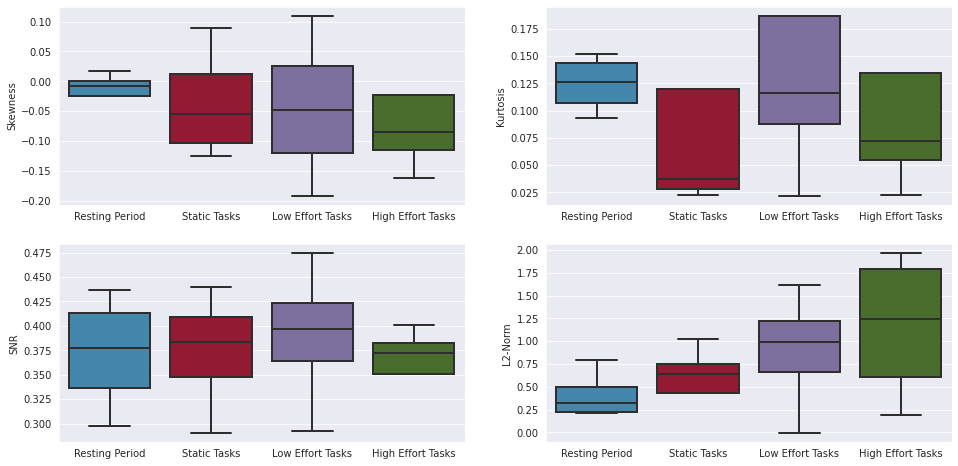

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
#fig.suptitle('Mean SQI per Class for all User [PPG]')

plt.style.use("bmh")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = "white"

plt.subplot(2, 2, 1)
p = sns.boxplot(y="skewness", x="label", data=df_adl_mean[df_adl_mean.label >= 0], showfliers = False);
p.set_xlabel(None);
p.set_ylabel("Skewness");
p.set_xticklabels(('Resting Period', 'Static Tasks','Low Effort Tasks', 'High Effort Tasks'));

plt.subplot(2, 2, 2)
q = sns.boxplot(y="sqi_kurtosis", x="label", data=df_adl_mean[df_adl_mean.label >= 0], showfliers = False);
q.set_xlabel(None);
q.set_ylabel("Kurtosis");
q.set_xticklabels(('Resting Period', 'Static Tasks','Low Effort Tasks', 'High Effort Tasks'));

plt.subplot(2, 2, 3)
u = sns.boxplot(y="snr", x="label", data=df_adl_mean[df_adl_mean.label >= 0], showfliers = False);
u.set_xlabel(None);
u.set_ylabel("SNR");
u.set_xticklabels(('Resting Period', 'Static Tasks','Low Effort Tasks', 'High Effort Tasks'));

plt.subplot(2, 2, 4)
v = sns.boxplot(y="euc_distance", x="label", data=df_adl_mean[df_adl_mean.label >= 0], showfliers = False);
v.set_xlabel(None);
v.set_ylabel("L2-Norm");
v.set_xticklabels(('Resting Period', 'Static Tasks','Low Effort Tasks', 'High Effort Tasks'));

#### Pairwise Tukey for Signal Quality

In [9]:
pt = pg.pairwise_tukey(dv='skewness', between='label', data=df_adl_mean[df_adl_mean.label >= 0]).round(5)
print(pt)

     A    B  mean(A)  mean(B)     diff       se        T  p-tukey   hedges
0  0.0  1.0 -0.01725 -0.03651  0.01926  0.07307  0.26363  0.99324  0.16210
1  0.0  2.0 -0.01725 -0.04497  0.02772  0.07307  0.37937  0.98053  0.23326
2  0.0  3.0 -0.01725 -0.05191  0.03465  0.07307  0.47427  0.96334  0.29162
3  1.0  2.0 -0.03651 -0.04497  0.00846  0.07307  0.11574  0.99941  0.07117
4  1.0  3.0 -0.03651 -0.05191  0.01539  0.07307  0.21064  0.99651  0.12952
5  2.0  3.0 -0.04497 -0.05191  0.00693  0.07307  0.09490  0.99968  0.05835


In [10]:
pt = pg.pairwise_tukey(dv='sqi_kurtosis', between='label', data=df_adl_mean[df_adl_mean.label >= 0]).round(5)
print(pt)

     A    B  mean(A)  mean(B)     diff       se        T  p-tukey   hedges
0  0.0  1.0  0.12421  0.10959  0.01462  0.08932  0.16369  0.99835  0.10065
1  0.0  2.0  0.12421  0.15802 -0.03381  0.08932 -0.37851  0.98066 -0.23274
2  0.0  3.0  0.12421  0.11728  0.00693  0.08932  0.07758  0.99982  0.04770
3  1.0  2.0  0.10959  0.15802 -0.04843  0.08932 -0.54220  0.94689 -0.33338
4  1.0  3.0  0.10959  0.11728 -0.00769  0.08932 -0.08611  0.99976 -0.05294
5  2.0  3.0  0.15802  0.11728  0.04074  0.08932  0.45609  0.96715  0.28044


In [11]:
pt = pg.pairwise_tukey(dv='snr', between='label', data=df_adl_mean[df_adl_mean.label >= 0]).round(5)
print(pt)

     A    B  mean(A)  mean(B)     diff       se        T  p-tukey   hedges
0  0.0  1.0  0.37210  0.37424 -0.00214  0.04359 -0.04901  0.99996 -0.03013
1  0.0  2.0  0.37210  0.39029 -0.01819  0.04359 -0.41723  0.97446 -0.25654
2  0.0  3.0  0.37210  0.36177  0.01033  0.04359  0.23711  0.99505  0.14579
3  1.0  2.0  0.37424  0.39029 -0.01605  0.04359 -0.36822  0.98213 -0.22641
4  1.0  3.0  0.37424  0.36177  0.01247  0.04359  0.28611  0.99141  0.17592
5  2.0  3.0  0.39029  0.36177  0.02852  0.04359  0.65433  0.91201  0.40233


In [12]:
pt = pg.pairwise_tukey(dv='euc_distance', between='label', data=df_adl_mean[df_adl_mean.label >= 0]).round(5)
print(pt)

     A    B  mean(A)  mean(B)     diff       se        T  p-tukey   hedges
0  0.0  1.0  0.40897  0.54709 -0.13812  0.42678 -0.32363  0.98770 -0.19899
1  0.0  2.0  0.40897  0.89588 -0.48691  0.42678 -1.14089  0.67270 -0.70151
2  0.0  3.0  0.40897  1.15854 -0.74957  0.42678 -1.75633  0.33918 -1.07992
3  1.0  2.0  0.54709  0.89588 -0.34879  0.42678 -0.81726  0.84523 -0.50252
4  1.0  3.0  0.54709  1.15854 -0.61145  0.42678 -1.43270  0.50423 -0.88093
5  2.0  3.0  0.89588  1.15854 -0.26266  0.42678 -0.61544  0.92519 -0.37842


### Completeness of good-quality data

In [13]:
folder_path = os.path.join(path_parent,'src')
if not os.path.isdir(folder_path +"/output"):
    os.makedirs(folder_path+"/output")
df_pass_rates = pd.DataFrame()
consecutive_list = []
for user in users_list:
    df_user = df_adl[df_adl_normalized.user==user]
    df_thresholds, passing_rate = signal_functions.threshold_analysis(df_user, show=False)
    df_user = df_user.assign(final=df_thresholds.final)

    file_name = "output/ppg_hr_" + str(user) + ".csv"
    fullname = os.path.join(folder_path, file_name)
    df_user.to_csv(fullname, index=True)

    # calculating the maximum number of consecutive bad-quality templates
    temp_value = 0
    for value in df_thresholds.final:
        if temp_value > 0:
            if value:
                consecutive_list.append(temp_value)
                temp_value = 0
            else:
                temp_value = temp_value + 1
        else:
            if not value:
                temp_value = 1

    passing_rate = pd.DataFrame([passing_rate])
    df_pass_rates = pd.concat([df_pass_rates, passing_rate], ignore_index=True)

file_name = "output/ppg_users_passing_rates.csv"
fullname = os.path.join(folder_path, file_name)
df_pass_rates.to_csv(fullname, index=True)

#print("Maximum of consecutive False is: ", max(consecutive_list))
#plt.hist(consecutive_list, 20);

In [14]:
df_pass_rates

,0,1,2,3
0,89.743590,85.652174,86.649874,86.816269
1,88.108108,89.339752,85.520362,84.957020
2,89.690722,85.880640,84.923077,84.979138
3,90.625000,87.422935,84.226190,83.582090


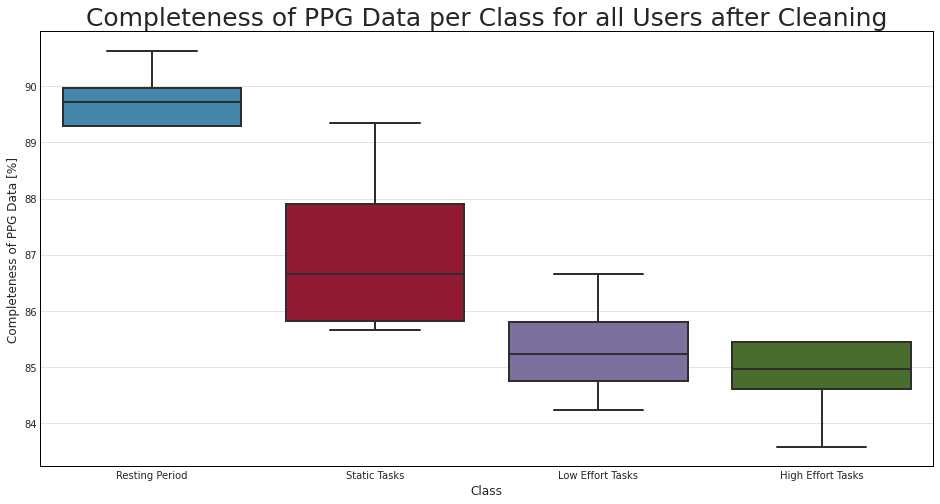

In [15]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.style.use("bmh")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
sns.boxplot(data=df_pass_rates, showfliers=False);
ax.set_title('Completeness of PPG Data per Class for all Users after Cleaning', fontsize=25);
ax.set_xlabel("Class");
ax.set_ylabel("Completeness of PPG Data [%]");
ax.set_xticklabels(('Resting Period', 'Static Tasks','Low Effort Tasks', 'High Effort Tasks'));

#### Pairwise Tukey for Data Completeness

In [16]:
df_split_passrates = pd.melt(df_pass_rates)
pt = pg.pairwise_tukey(dv='value', between='variable', data=df_split_passrates)
print(pt)

   A  B    mean(A)    mean(B)      diff        se         T   p-tukey  \
0  0  1  89.541855  87.073875  2.467980  0.922828  2.674366  0.082646   
1  0  2  89.541855  85.329876  4.211979  0.922828  4.564208  0.003140   
2  0  3  89.541855  85.083629  4.458226  0.922828  4.831047  0.002008   
3  1  2  87.073875  85.329876  1.743999  0.922828  1.889842  0.282467   
4  1  3  87.073875  85.083629  1.990246  0.922828  2.156682  0.190706   
5  2  3  85.329876  85.083629  0.246247  0.922828  0.266839  0.992996   

     hedges  
0  1.644402  
1  2.806420  
2  2.970493  
3  1.162018  
4  1.326091  
5  0.164073  


### EXTRAS: If csv-files available

- pass rates from ECG and PPG in one csv such as: *example_ecg_ppg_passrates.csv*
- euclidian cost from heart rate and pulse rate such as: *example_euclidian_cost.csv*

#### Completeness of ECG and PPG Data compared

In [17]:
cwd = os.getcwd()
file_name = "examples/example_ecg_ppg_passrates.csv"
file_path = os.path.join(cwd, file_name)
passrates_total = pd.read_csv(file_path)
passrates_total

,signal,0,1,2,3
0,PPG,89.743590,85.652174,86.649874,86.816269
1,PPG,88.108108,89.339752,85.520362,84.957020
2,PPG,89.690722,85.880640,84.923077,84.979138
3,PPG,90.625000,87.422935,84.226190,83.582090
4,ECG,86.131387,22.718053,21.612903,7.325383
5,ECG,89.808917,75.848461,76.497696,66.205837
6,ECG,87.421384,62.673611,29.710145,18.027735
7,ECG,91.975309,66.494179,80.530973,50.082102


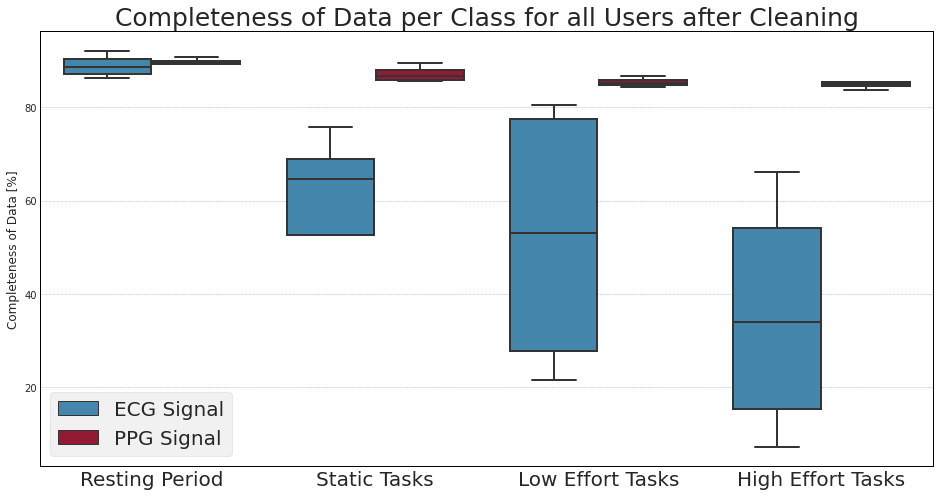

In [18]:
df_split_ecg_ppg = pd.melt(passrates_total, id_vars="signal")
df_split_ecg_ppg.sort_values(["signal", "variable"], inplace=True)

plt.style.use("bmh")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1

fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(x="variable", y="value", hue="signal", data=df_split_ecg_ppg, showfliers = False)
ax.set_title('Completeness of Data per Class for all Users after Cleaning', fontsize=25);
ax.set_xlabel("");
ax.set_ylabel("Completeness of Data [%]");
ax.set_xticklabels(('Resting Period', 'Static Tasks','Low Effort Tasks', 'High Effort Tasks'), fontsize=20);
ax.set(facecolor = "white")
L = plt.legend(fontsize=20)
L.get_texts()[0].set_text('ECG Signal')
L.get_texts()[1].set_text('PPG Signal')
plt.rcParams["legend.loc"] = "lower left"

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0_PPG vs. 2_PPG: *
0_PPG vs. 3_PPG: *
0_ECG vs. 3_ECG: *


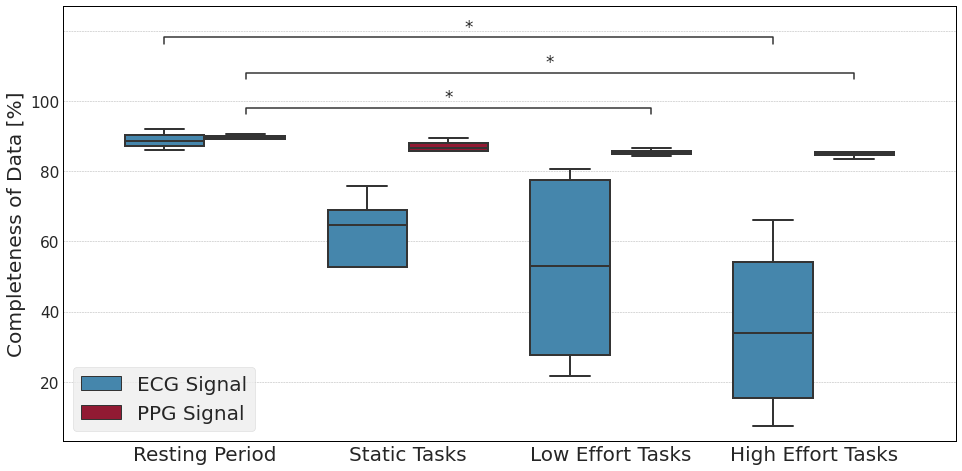

In [19]:
plotting_parameters = {
    'data':    df_split_ecg_ppg,
    'x':       'variable',
    'y':       'value',
    'hue':     'signal',
    'showfliers': False
}

pairs = [
    [('0', 'PPG'), ('2', 'PPG')],
    [('0', 'PPG'), ('3', 'PPG')],
    [('0', 'ECG'), ('3', 'ECG')]
]

formatted_pvalues=['*', '*', '*']

with sns.plotting_context('notebook', font_scale = 1.4):
    # Create new plot
    plt.style.use("bmh")
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    fig, ax = plt.subplots(figsize=(16,8))

    # Plot with seaborn
    sns.boxplot(**plotting_parameters)

    # Add annotations
    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.set_custom_annotations(formatted_pvalues)
    annotator.annotate()

    #ax.set_title('Completeness of Data per Class for all Users after Cleaning', fontsize=25);
    ax.set_xlabel("");
    ax.set_ylabel("Completeness of Data [%]");
    y1 = [20,40,60,80,100,120]
    squad = ['20','40','60','80','100', '']
    ax.set_yticks(y1, fontsize=30)
    ax.set_yticklabels(squad, minor=False)
    ax.set_xticklabels(('Resting Period', 'Static Tasks','Low Effort Tasks', 'High Effort Tasks'), fontsize=20);
    ax.set(facecolor = "white")
    L = plt.legend(fontsize=20)
    L.get_texts()[0].set_text('ECG Signal')
    L.get_texts()[1].set_text('PPG Signal')
    plt.rcParams["legend.loc"] = "lower left"

    # Label and show
    plt.show()

#### L2 Norm of Heart Rate and Pulse Rate Compared

In [20]:
cwd = os.getcwd()
file_name = "examples/example_euclidian_cost.csv"
file_path = os.path.join(cwd, file_name)
euc_cost_total = pd.read_csv(file_path).drop(['Unnamed: 0'], axis=1)
euc_cost_total

,-1,0,1,2,3
0,14.392830,3.782103,7.724408,11.164091,9.256975
1,5.029522,2.800324,3.683363,2.796577,5.112762
2,7.838933,2.909393,4.569938,6.433530,8.495889
3,11.164091,2.755367,4.875549,2.646372,5.792832


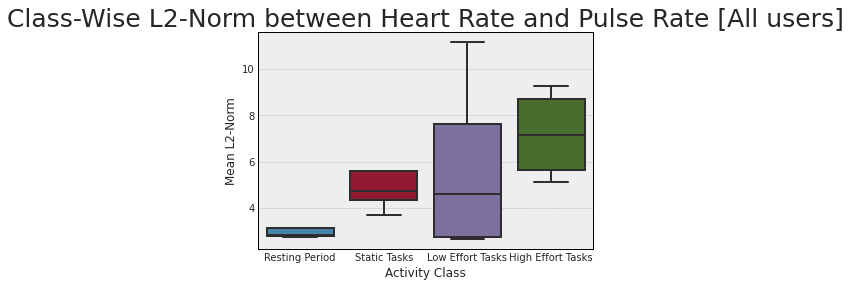

In [21]:
df_split_euclidian_cost = pd.melt(euc_cost_total.iloc[:,1:])
p = sns.boxplot(x="variable", y="value", data=df_split_euclidian_cost, showfliers=False);
p.set_title('Class-Wise L2-Norm between Heart Rate and Pulse Rate [All users]', fontsize=25);
p.set_xlabel("Activity Class");
p.set_ylabel("Mean L2-Norm");
p.set_xticklabels(('Resting Period', 'Static Tasks','Low Effort Tasks', 'High Effort Tasks'));

In [22]:
pt = pg.pairwise_tukey(dv='value', between='variable', data=df_split_euclidian_cost)
print(pt)

   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  3.061797  5.213314 -2.151517  1.710936 -1.257509  0.604779 -0.773211
1  0  2  3.061797  5.760142 -2.698345  1.710936 -1.577117  0.426271 -0.969730
2  0  3  3.061797  7.164615 -4.102818  1.710936 -2.397996  0.130412 -1.474469
3  1  2  5.213314  5.760142 -0.546828  1.710936 -0.319607  0.988135 -0.196519
4  1  3  5.213314  7.164615 -1.951300  1.710936 -1.140487  0.672932 -0.701257
5  2  3  5.760142  7.164615 -1.404472  1.710936 -0.820879  0.843552 -0.504739
